In [1]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score 

/home/valentxi/miniconda3/envs/msc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv('./Data/cardiovascular_train.csv')
train_df.columns

Index(['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',
       'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
       'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile',
       'SocioeconomicStatus'],
      dtype='object')

In [13]:
nodes = [
    'Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',
    'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
    'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile',
    'SocioeconomicStatus']

bm = BayesianNetwork()
bm.add_nodes_from(nodes)
bm.add_edges_from([('SocioeconomicStatus', 'Diabetes')])

#bm.add_edges_from([('PhysicalActivity','BodyMassIndex'), ('PhysicalActivity','Hypertension'), ('Age','Diabetes'), ('BodyMassIndex','Diabetes'), ('BodyMassIndex','Hypertension'), ('BodyMassIndex','Hypercholesterolemia'), ('SleepDuration','Depression'), ('SmokerProfile','Hypertension'), ('SmokerProfile','Hypercholesterolemia')])

In [ ]:
pe = ParameterEstimator(bm, train_df)

for col in nodes:

    print("\n", pe.state_counts(col)) 
#print("\n", pe.state_counts('BodyMassIndex')) 
#print("\n", pe.state_counts('PhysicalActivity')) 
#print("\n", pe.state_counts('SocioeconomicStatus'))

In [ ]:
mle_est = MaximumLikelihoodEstimator(model=bm, data=train_df)
print(mle_est.estimate_cpd(node="Hypertension")) #Dado o BMI

In [ ]:
mle_est.get_parameters()

In [ ]:
for c in mle_est.get_parameters():
    print(c)

In [ ]:
bm.fit(train_df, estimator=BayesianEstimator, prior_type='K2')
for cpd in bm.get_cpds():
    print(cpd)

In [ ]:
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

In [ ]:
for cpd in bm.get_cpds():
    print_full(cpd)

In [5]:
from pgmpy.base import DAG

def initialize_graph(nodes,p=1):
  G = DAG()
  G.add_nodes_from(nodes=nodes)
  init = G.get_random(n_nodes=len(nodes), edge_prob=p)
  ls = []
  mapping = {}
  for k in range(len(nodes)):
      mapping[k] = nodes[k]
  for i,j in init.edges:
    ls.append((mapping[i],mapping[j]))
  ls
  G.add_edges_from(ebunch=ls) # G is the required initialization for the Hill Climbing method
  return G

In [14]:
k2 = K2Score(train_df)
es = HillClimbSearch(data=train_df)
best_model = es.estimate(scoring_method=k2, start_dag=initialize_graph(nodes=nodes, p=0.2))
print('Edges:', best_model.edges())
print('Bayesian score:', k2.score(best_model))


  0%|          | 53/1000000 [00:01<7:30:34, 36.99it/s] 

Edges: [('Anxiety', 'SocioeconomicStatus'), ('Anxiety', 'SmokerProfile'), ('Anxiety', 'Age'), ('BodyMassIndex', 'Hypertension'), ('BodyMassIndex', 'SmokerProfile'), ('BodyMassIndex', 'SocioeconomicStatus'), ('BodyMassIndex', 'Age'), ('Depression', 'SocioeconomicStatus'), ('Depression', 'SmokerProfile'), ('Depression', 'Age'), ('Depression', 'PhysicalActivity'), ('Diabetes', 'SocioeconomicStatus'), ('Diabetes', 'SmokerProfile'), ('Diabetes', 'PhysicalActivity'), ('Diabetes', 'Age'), ('Diabetes', 'Sex'), ('EducationLevel', 'Hypercholesterolemia'), ('EducationLevel', 'SocioeconomicStatus'), ('EducationLevel', 'SmokerProfile'), ('EducationLevel', 'Age'), ('Hypercholesterolemia', 'SocioeconomicStatus'), ('Hypercholesterolemia', 'SmokerProfile'), ('Hypercholesterolemia', 'Age'), ('Hypercholesterolemia', 'Sex'), ('Hypertension', 'SmokerProfile'), ('Hypertension', 'SocioeconomicStatus'), ('Hypertension', 'Age'), ('Hypertension', 'Hypercholesterolemia'), ('Hypertension', 'Anxiety'), ('PhysicalA

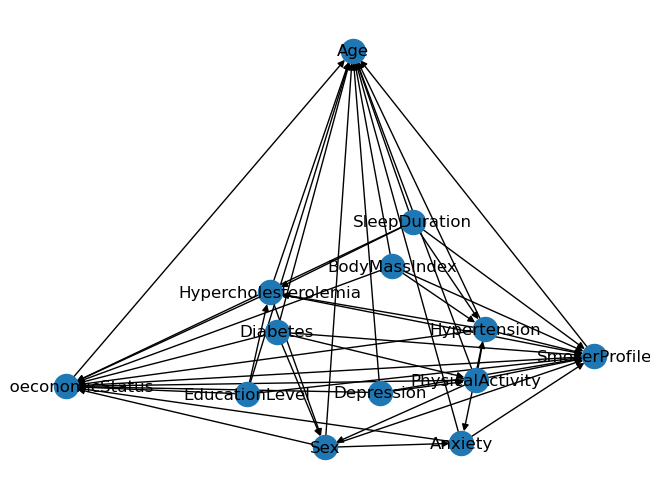

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

nx.draw(nx.DiGraph(best_model.edges()), with_labels=True)
plt.draw()